In [1]:
# Importing Libraries
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier,  RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.metrics import classification_report , make_scorer
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import RandomOverSampler
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.discriminant_analysis import StandardScaler
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
import pickle
import timeit

In [2]:
df = pd.read_csv("ddos.csv")

In [3]:
df.head()

,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Inbound,Label
0,6,188912,4,2,24.0,12.0,6.0,6.0,6.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,LDAP
1,6,183,2,2,12.0,12.0,6.0,6.0,6.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,LDAP
2,6,168997,4,2,24.0,12.0,6.0,6.0,6.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,LDAP
3,6,151583,4,2,24.0,12.0,6.0,6.0,6.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,LDAP
4,17,3,2,0,458.0,0.0,229.0,229.0,229.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,LDAP


# Analyse de Forme :

In [4]:
df[' Label'].value_counts()

LDAP       200000
NetBIOS    200000
MSSQL      200000
UDP        200000
Syn        199997
Portmap    186960
BENIGN      56923
UDPLag       1873
Name:  Label, dtype: int64

Text(0.5, 1.0, 'Class Distributions ')

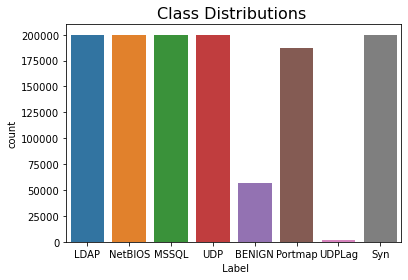

In [5]:
sns.countplot(x=' Label',data=df)
plt.title('Class Distributions ', fontsize=16)


# Preprocessing :

In [6]:
def encodage(df):
    code ={'BENIGN':0, 
       'LDAP': 1,
       'NetBIOS':2,
       'MSSQL':3,
       'UDP':4,
       'Portmap':2,
       'UDPLag':5,
       'Syn':6
       }
    
    df[' Label'] = df[' Label'].map(code)
   
    return df



In [7]:
df = encodage(df)   
y = df[' Label'] 
X= df.drop(' Label', axis=1)

In [8]:
ros = RandomOverSampler(random_state=42)
X_ros, y_ros= ros.fit_resample(X, y)
y_ros.value_counts()


1    386960
2    386960
3    386960
4    386960
0    386960
5    386960
6    386960
Name:  Label, dtype: int64

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X_ros, y_ros, test_size=0.2, random_state=4)

In [10]:
scaler = StandardScaler()
X_train= scaler.fit_transform(X_train)
X_test= scaler.transform(X_test)


# Modellisation :

In [11]:
#Voting

voting  = VotingClassifier([('GNB', GaussianNB()),
                            ('Tree', DecisionTreeClassifier(random_state=0)),
                            ('KNN', KNeighborsClassifier())],
                           voting='hard',n_jobs=-1)


#Bagging
bagging = BaggingClassifier(base_estimator=KNeighborsClassifier())
RandomForest = RandomForestClassifier(n_estimators=100,random_state=0)


#Boosting 
AdaBoost = AdaBoostClassifier(DecisionTreeClassifier())
GradBoost = GradientBoostingClassifier(random_state=0)
XGBC= XGBClassifier()
LGBM = LGBMClassifier()
CatBC = CatBoostClassifier()
hist = HistGradientBoostingClassifier()


#Stacking
Stack = StackingClassifier([('GNB', GaussianNB()), 
                            ('Tree', DecisionTreeClassifier(random_state=0)),
                            ('KNN', KNeighborsClassifier())],
                           final_estimator=KNeighborsClassifier())

In [12]:

dict_of_models = {
                  'voting' : voting,
                  'bagging' : bagging,
                  'RandomForest': RandomForest,
                  'GradBoost' :GradBoost,
                  'XGBClassifier' : XGBC,
                  'LGBM' : LGBM,
                  'CatBC' : CatBC,         
                  'AdaBoost' : AdaBoost,
                  'lpboost' : lpboost,
                  'hist' : hist,
                  'stack' : Stack
                  }


# Procédure d'évaluation :

In [13]:


def evaluation_test(model,name=None):
    
    if name is None:
        name = model.__class__.__name__

    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(21, 6))

    # Train the model on the full training set
    start_time = timeit.default_timer()
    model.fit(X_train, y_train)
    

    # Make predictions on test data (X_test)
    ypred = model.predict(X_test)

    # score
    f1 = f1_score(y_test, ypred, average='micro')
    print(f" Score: {f1}")

    # plot confusion matrix
    cf_matrix = confusion_matrix(y_test, ypred)
    sns.heatmap(cf_matrix, annot=True, fmt=".0f", ax=axes[0])
    axes[0].set_title(f"{name} Confusion Matrix")

    # plot classification report
    report = classification_report(y_test, ypred, output_dict=True)
    report_df = pd.DataFrame(report).transpose()
    sns.heatmap(report_df, annot=True, cmap='Blues', ax=axes[1])
    axes[1].set_title(f"{name} Classification Report")

    # plot normalized confusion matrix
    cm_normalized = cf_matrix/np.sum(cf_matrix, axis=1).reshape(-1,1)
    sns.heatmap(cm_normalized, annot=True, fmt='.2%', ax=axes[2])
    axes[2].set_title(f"{name} Normalized Confusion Matrix")

    # Plot cross-validation scores
    scorer = make_scorer(f1_score, average='micro')
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring=scorer)
    print(f"{name} Cross-Validation Scores: {scores}")
    print(f"Mean Score: {np.mean(scores)}")
    print(f"Standard Deviation: {np.std(scores)}")
    elapsed_time = timeit.default_timer() - start_time

    print(f"Elapsed Time (s): {elapsed_time:.4f}")
    plt.show()
    

    # Save the model to a file
    with open('model_'+name+'.pkl', 'wb') as file:
        pickle.dump(model, file)
    

voting Cross-Validation Scores: [0.9894946  0.98963301 0.98953841 0.98995835 0.98958917]
Mean Score: 0.9896427095399826
Standard Deviation: 0.00016456358850488608
Elapsed Time (s): 11486.9350


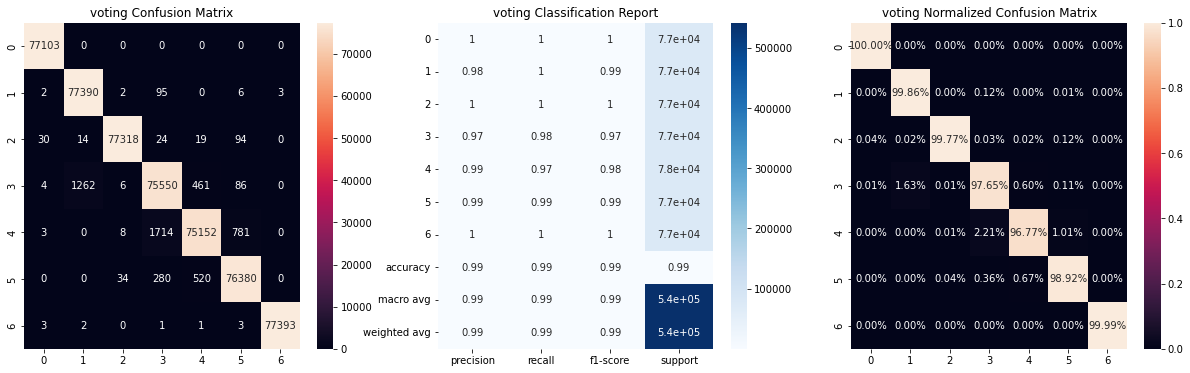

bagging Cross-Validation Scores: [0.99072442 0.99091129 0.99088591 0.99129432 0.99091822]
Mean Score: 0.9909468310781536
Standard Deviation: 0.00018761979707448078
Elapsed Time (s): 111236.8636


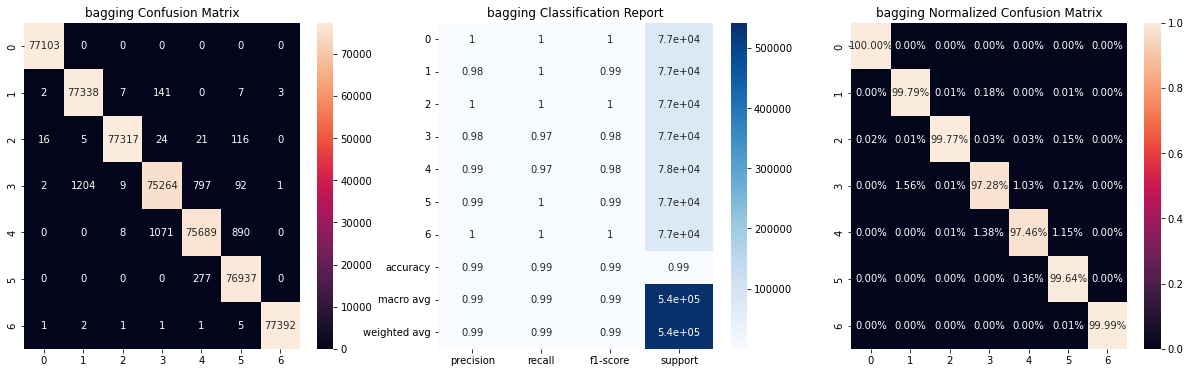

RandomForest Cross-Validation Scores: [0.98917387 0.98962148 0.98935152 0.98983837 0.98936305]
Mean Score: 0.9894696573915835
Standard Deviation: 0.00023315572913425474
Elapsed Time (s): 3732.6791


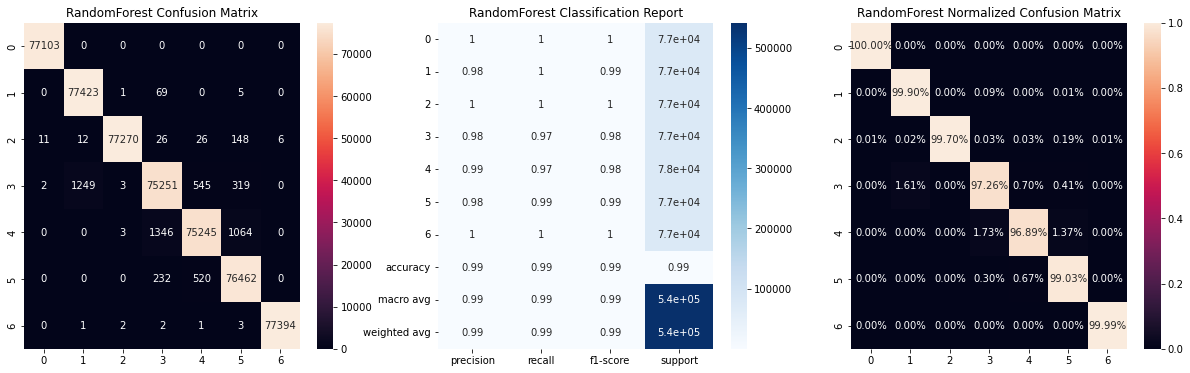

GradBoost Cross-Validation Scores: [0.98681345 0.98723797 0.98723336 0.98712029 0.98695416]
Mean Score: 0.9870718458618832
Standard Deviation: 0.0001653175835761317
Elapsed Time (s): 64580.0929


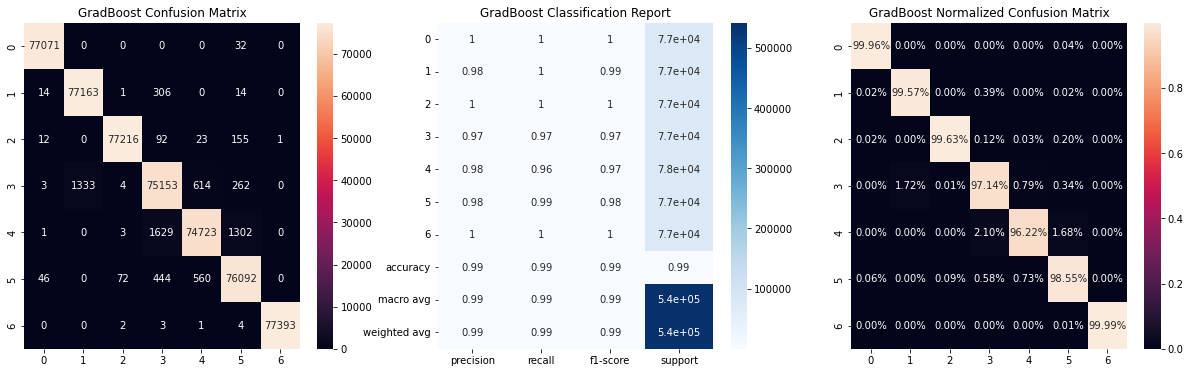

XGBClassifier Cross-Validation Scores: [0.99126434 0.99151582 0.99140968 0.99171656 0.99140738]
Mean Score: 0.9914627574086733
Standard Deviation: 0.00014999107186036418
Elapsed Time (s): 11768.9809


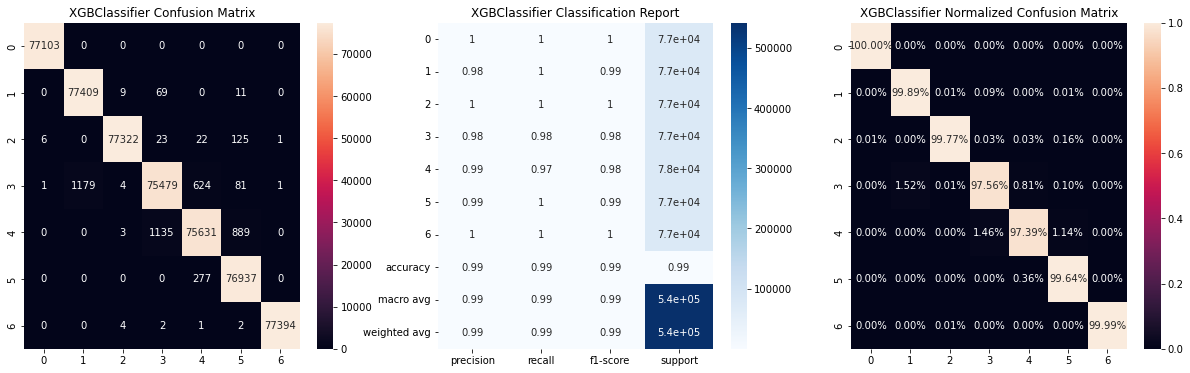

LGBM Cross-Validation Scores: [0.94322283 0.97562962 0.98048662 0.9458577  0.97239239]
Mean Score: 0.9635178332824209
Standard Deviation: 0.015729974316903074
Elapsed Time (s): 569.2785


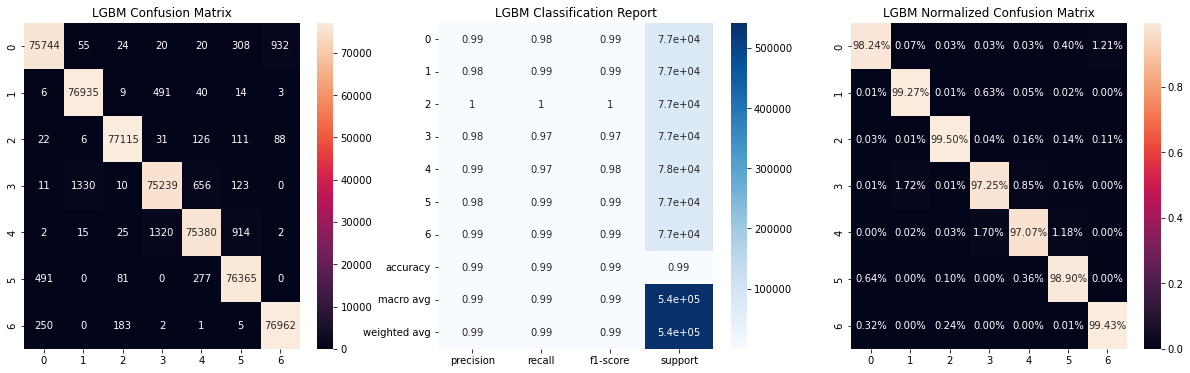

Learning rate set to 0.117072
0:	learn: 1.4227468	total: 4.53s	remaining: 1h 15m 27s
1:	learn: 1.1468768	total: 8.23s	remaining: 1h 8m 29s
2:	learn: 0.9696680	total: 11.9s	remaining: 1h 5m 48s
3:	learn: 0.8350047	total: 15.5s	remaining: 1h 4m 14s
4:	learn: 0.7323834	total: 18.7s	remaining: 1h 2m 7s
5:	learn: 0.6505433	total: 22.1s	remaining: 1h 55s
6:	learn: 0.5834041	total: 25.6s	remaining: 1h 25s
7:	learn: 0.5259722	total: 28.8s	remaining: 59m 29s
8:	learn: 0.4782662	total: 31.9s	remaining: 58m 37s
9:	learn: 0.4345816	total: 35.2s	remaining: 58m 7s
10:	learn: 0.3984059	total: 38.6s	remaining: 57m 54s
11:	learn: 0.3665386	total: 42.4s	remaining: 58m 8s
12:	learn: 0.3395797	total: 45.4s	remaining: 57m 28s
13:	learn: 0.3136991	total: 48.8s	remaining: 57m 17s
14:	learn: 0.2919888	total: 52.4s	remaining: 57m 19s
15:	learn: 0.2738247	total: 55.5s	remaining: 56m 51s
16:	learn: 0.2579080	total: 59.5s	remaining: 57m 18s
17:	learn: 0.2436522	total: 1m 2s	remaining: 57m 8s
18:	learn: 0.2285742	

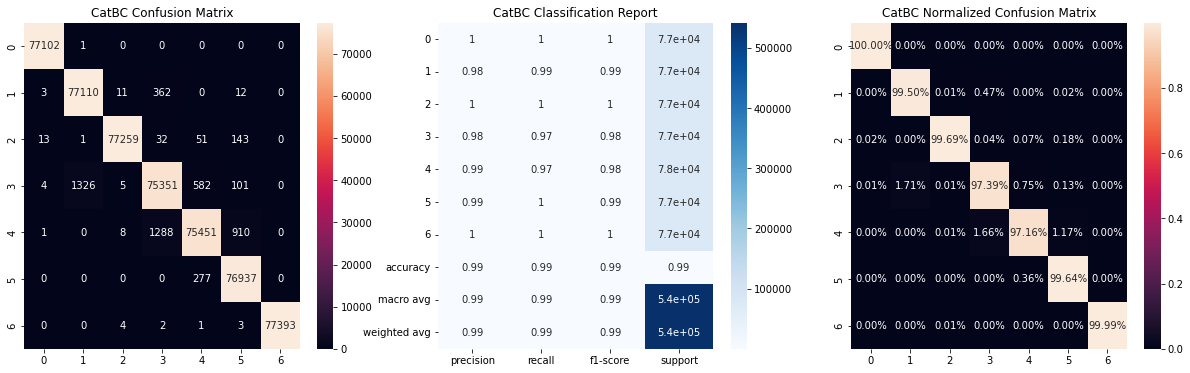

AdaBoost Cross-Validation Scores: [0.98917157 0.98953149 0.98944612 0.98983606 0.98938613]
Mean Score: 0.9894742721205525
Standard Deviation: 0.00021649901093348897
Elapsed Time (s): 17670.1604


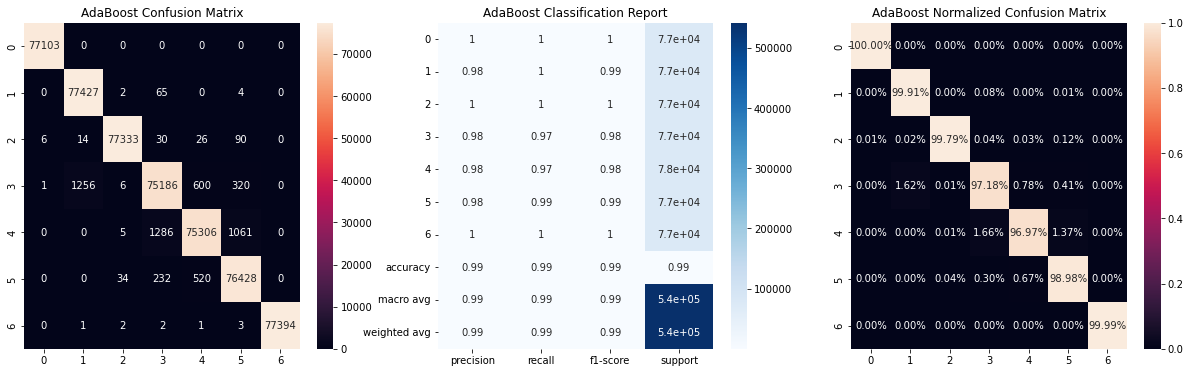

lpboost Cross-Validation Scores: [0.70925897 0.70716321 0.69005411 0.68918192 0.69046482]
Mean Score: 0.6972246060711504
Standard Deviation: 0.009004413010131012
Elapsed Time (s): 3731.5654


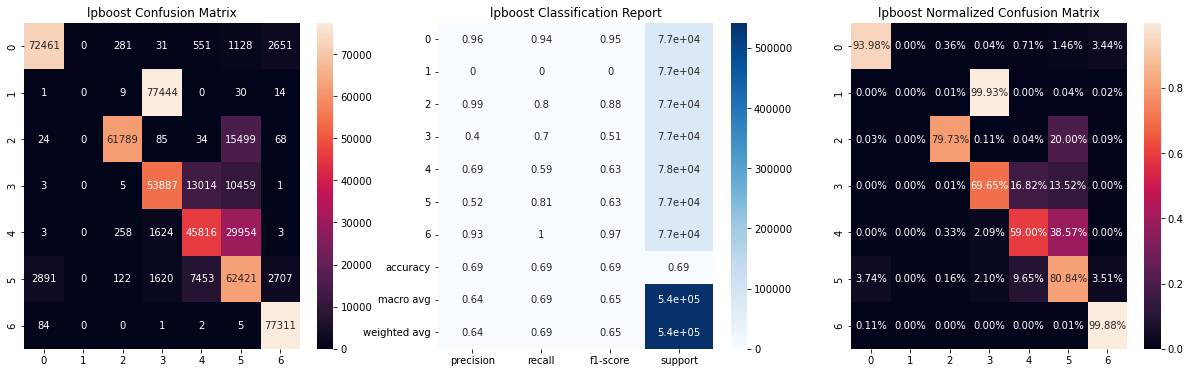

hist Cross-Validation Scores: [0.98941153 0.9905675  0.99044751 0.99001142 0.98984991]
Mean Score: 0.990057573616894
Standard Deviation: 0.0004182584170541055
Elapsed Time (s): 884.1311


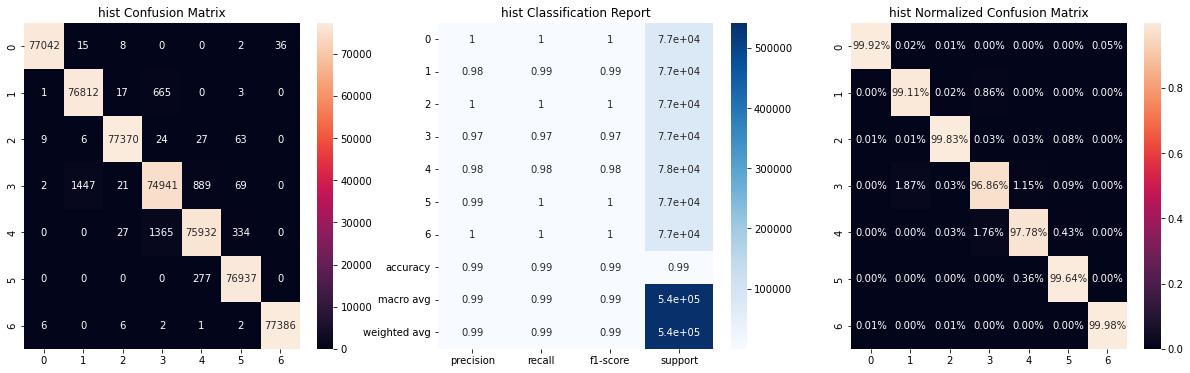

stack Cross-Validation Scores: [0.98472529 0.99058134 0.97961675 0.98851394 0.99081438]
Mean Score: 0.986850339886115
Standard Deviation: 0.004224743935711136
Elapsed Time (s): 59828.1624


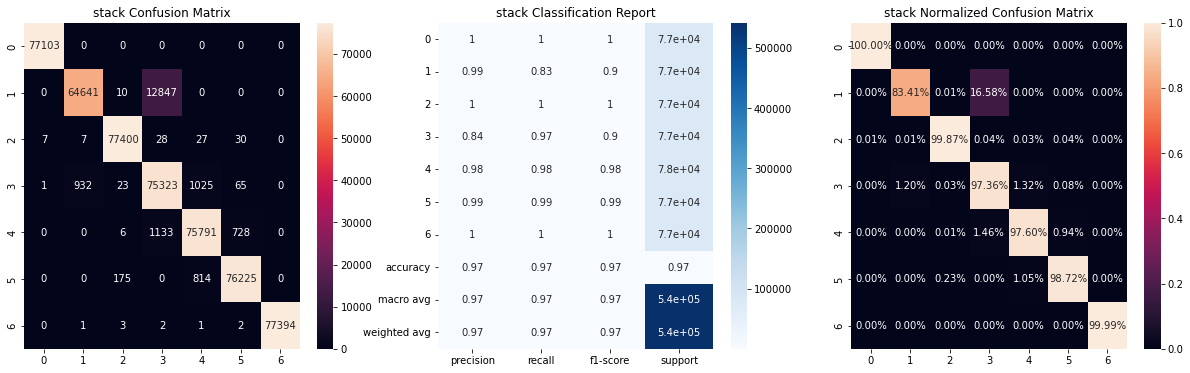

In [14]:
# Iterate over all models in dict_of_models
for name, model in dict_of_models.items():
    evaluation_test(model,name)